In [1]:
import pandas as pd

METADATA = "../data/metadata.csv"
S2W = "../data/Screen2Words_tfidf.csv"


MOST_POPULAR_CATEGORIES = ["Education","Business","Entertainment","Music & Audio","Food & Drink","Shopping","Lifestyle","Books & Reference","Health & Fitness","Finance"]

In [2]:
#import metadata and s2w dataset with tfidf score

metadata = pd.read_csv(METADATA)
metadata.drop(columns=["Unnamed: 0"], inplace=True)
metadata.rename(columns={"UI Number": "screenId"}, inplace=True)

s2w = pd.read_csv(S2W)
s2w.drop(columns=["Unnamed: 0"], inplace=True)

In [3]:
#add tfidf score to s2w dataset

metadata_tfidf = pd.merge(metadata, s2w[["screenId","tfidf_grouped_sum"]].drop_duplicates(), on="screenId")
metadata_tfidf = metadata_tfidf[metadata_tfidf['Category'].isin(MOST_POPULAR_CATEGORIES)]

In [4]:
#function, where each 50 samples from a dataframe are selected

def sampling_data (df, sample_amount=50):
    df['strata'] = pd.qcut(df['tfidf_grouped_sum'], sample_amount, labels=False)
    df = df.groupby('strata').apply(lambda x: x.sample(n=1))
    df = df.reset_index(drop=True)
    df = df.drop(columns=["strata"])
    return df

In [5]:
#spliting the datasframe into a set of dataframes based on the App category

categories = {k: v for k, v in metadata_tfidf.groupby('Category')}

for key, df in categories.items():
    # Apply the function to each DataFrame
    categories[key] = sampling_data(df)

    # You can store the result or print it
    print(f"sample for {key}")


sample for Books & Reference
sample for Business
sample for Education
sample for Entertainment
sample for Finance
sample for Food & Drink
sample for Health & Fitness
sample for Lifestyle
sample for Music & Audio
sample for Shopping


In [6]:
combined_sample = pd.concat(categories.values(), ignore_index=True)
combined_sample

,App Package Name,Play Store Name,Category,Average Rating,Number of Ratings,Number of Downloads,Date Updated,screenId,Interaction Trace Number,UI Number in Trace,split,tfidf_grouped_sum
0,us.pacourts.docket,PAeDocket,Books & Reference,4.4,156,"50,000 - 100,000","February 10, 2017",55521,0,400,train,7.328023
1,joansoft.dailybible,Daily Bible,Books & Reference,4.7,169034,"5,000,000 - 10,000,000","May 5, 2017",9332,0,222,test,8.145251
2,org.superappsforall.prayerbook,Prayer book,Books & Reference,4.4,605,"100,000 - 500,000","January 8, 2016",16442,0,511,train,8.308665
3,x.abcd,Hacking Tutorials 2.0,Books & Reference,4.3,30071,"1,000,000 - 5,000,000","February 21, 2015",65143,0,720,train,8.486382
4,com.mobilicos.howtotieknots,How to Tie Knots - 3D Animated,Books & Reference,4.0,2800,"100,000 - 500,000","December 15, 2015",47478,0,300,dev,8.611719
...,...,...,...,...,...,...,...,...,...,...,...,...
495,com.poqstudio.app.platform.boohoo,boohoo.com,Shopping,3.3,862,"500,000 - 1,000,000","April 25, 2017",18079,1,397,train,10.765239
496,com.jet.jet.app,Jet - Online Shopping Deals,Shopping,4.6,27632,"1,000,000 - 5,000,000","May 6, 2017",40656,2,232,train,10.834633
497,com.milanoo.store,Milanoo-Fashion Shopping,Shopping,3.9,1542,"100,000 - 500,000","March 1, 2017",7329,0,1287,train,10.940067
498,com.meamobile.printicular,Printicular Print Photos,Shopping,4.6,5319,"500,000 - 1,000,000","May 5, 2017",54998,0,362,train,11.036639


In [7]:
combined_sample["Category"].value_counts()

Category
Books & Reference    50
Business             50
Education            50
Entertainment        50
Finance              50
Food & Drink         50
Health & Fitness     50
Lifestyle            50
Music & Audio        50
Shopping             50
Name: count, dtype: int64

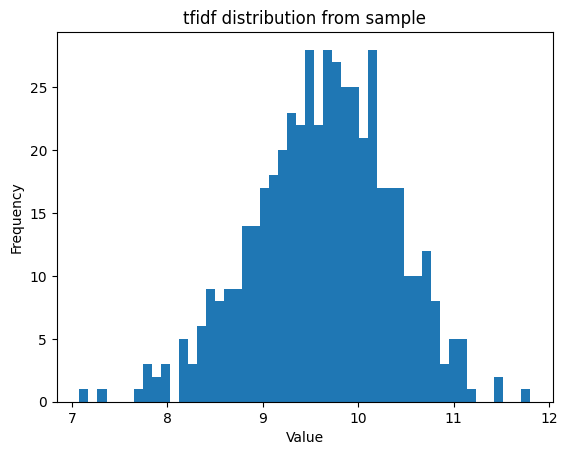

In [8]:
import matplotlib.pyplot as plt

data = combined_sample["tfidf_grouped_sum"]  # your large dataset
plt.hist(data, bins=50)  # Adjust the number of bins as needed
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('tfidf distribution from sample')
plt.show()

In [9]:
combined_sample.sort_values(by="screenId", inplace=True)
combined_sample.to_csv("../data/s2w_sample.csv")

In [10]:
from notebooks.prompts import SUMMARY_PROMPT_COT
from langchain.chat_models import ChatOpenAI
from langchain.chains import LLMChain
from langfuse.callback import CallbackHandler
import os
from dotenv import load_dotenv
from langchain.prompts import PromptTemplate


load_dotenv()
handler = CallbackHandler(os.environ.get("LANGFUSE_PUBLIC_KEY"), os.environ.get("LANGFUSE_SECRET_KEY"))

MODEL = "gpt-3.5-turbo"



ImportError: cannot import name 'SUMMARY_PROMPT_COT' from 'notebooks.prompts' (C:\Users\fiebi\Projects\generating-guis-with-LLMs\notebooks\prompts.py)

In [16]:
def create_summaries_s2w(id, prompt=SUMMARY_PROMPT_COT, temp=0):
    llm = ChatOpenAI(model_name=MODEL,temperature=temp)

    chain = LLMChain(llm=llm, prompt=prompt, callbacks=[handler])

    summaries = s2w[s2w["screenId"]==id]["summary"].values
    summaries_str = "\n".join([f"Summary {i+1}: {summary}" for i, summary in enumerate(summaries)])

    try: 
        response = chain.run(summaries=summaries_str, callbacks=[handler])
    except Exception as e:
        print(e)
    return response

In [17]:
create_summaries_s2w(27729)

'Certainly, let\'s break it down step by step:\n\nSummary 1: "App asking to translate the given sentence" - This suggests that it\'s an app that prompts the user to translate a specific sentence.\n\nSummary 2: "Page displaying about translating the sentence" - This indicates that there is a page within the app that provides information about the process of translating the sentence.\n\nSummary 3: "Page displaying the translation" - This implies that there is a page within the app that displays the translated version of the sentence.\n\nSummary 4: "Page to translate the text" - Similar to Summary 1, it mentions a page dedicated to translating text.\n\nSummary 5: "Screen page of language translator application" - This suggests that it\'s a screen within a language translator application.\n\nFrom these summaries, we can formulate a new description:\n\nThe mobile page is part of a language translator application and serves as a page where users can input a sentence to be translated. It also